In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dog-breed-identification1/Dog Breed Identification using Transfer Learning/dbi.ipynb
/kaggle/input/dog-breed-identification1/Dog Breed Identification using Transfer Learning/labels.csv
/kaggle/input/dog-breed-identification1/Dog Breed Identification using Transfer Learning/test/09e51e17e2b756ff2ace8a87bd1443fa.jpg
/kaggle/input/dog-breed-identification1/Dog Breed Identification using Transfer Learning/test/f7a32505c12649183c5991ecfa7d68b3.jpg
/kaggle/input/dog-breed-identification1/Dog Breed Identification using Transfer Learning/test/bc6d50ffb4644feb34530aa58943e85b.jpg
/kaggle/input/dog-breed-identification1/Dog Breed Identification using Transfer Learning/test/7cbc041e79135a572aad87904b5c9c57.jpg
/kaggle/input/dog-breed-identification1/Dog Breed Identification using Transfer Learning/test/f3b603f10d6a344f0395fb46b242ff8e.jpg
/kaggle/input/dog-breed-identification1/Dog Breed Identification using Transfer Learning/test/db55098d859d27a3c05b0e3fc41d43e7.jpg
/kaggle/input/d

In [2]:
import cv2
from glob import glob

In [3]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# MobileNetV2 Model

In [4]:
def build_model(size, num_classes):
    inputs = Input((size, size, 3))
    backbone = MobileNetV2(input_tensor=inputs, include_top=False, weights="imagenet")
    backbone.trainable = False
    x = backbone.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x)
    x = Dense(1024, activation="relu")(x)
    x = Dense(num_classes, activation="softmax")(x)
    model = tf.keras.Model(inputs, x)
    return model

**Image reading using cv2**

In [5]:
def read_image(path, size):
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (size, size))
    image = image / 255.0
    image = image.astype(np.float32)
    return image

In [6]:
def parse_data(x, y):
    x = x.decode()

    num_class = 120
    size = 224

    image = read_image(x, size)
    label = [0] * num_class
    label[y] = 1
    label = np.array(label)
    label = label.astype(np.int32)

    return image, label

In [7]:
def tf_parse(x, y):
    x, y = tf.numpy_function(parse_data, [x, y], [tf.float32, tf.int32])
    x.set_shape((224, 224, 3))
    y.set_shape((120))
    return x, y

In [8]:
def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    return dataset

In [9]:
path = "/kaggle/input/dog-breed-identification1/Dog Breed Identification using Transfer Learning/"
train_path = os.path.join(path, "train/*")
test_path = os.path.join(path, "test/*")
labels_path = os.path.join(path, "labels.csv")

In [10]:
labels_df = pd.read_csv(labels_path)
breed = labels_df["breed"].unique()
print("Number of Breed: ", len(breed))

Number of Breed:  120


In [11]:
breed2id = {name: i for i, name in enumerate(breed)}

In [12]:
breed2id

{'boston_bull': 0,
 'dingo': 1,
 'pekinese': 2,
 'bluetick': 3,
 'golden_retriever': 4,
 'bedlington_terrier': 5,
 'borzoi': 6,
 'basenji': 7,
 'scottish_deerhound': 8,
 'shetland_sheepdog': 9,
 'walker_hound': 10,
 'maltese_dog': 11,
 'norfolk_terrier': 12,
 'african_hunting_dog': 13,
 'wire-haired_fox_terrier': 14,
 'redbone': 15,
 'lakeland_terrier': 16,
 'boxer': 17,
 'doberman': 18,
 'otterhound': 19,
 'standard_schnauzer': 20,
 'irish_water_spaniel': 21,
 'black-and-tan_coonhound': 22,
 'cairn': 23,
 'affenpinscher': 24,
 'labrador_retriever': 25,
 'ibizan_hound': 26,
 'english_setter': 27,
 'weimaraner': 28,
 'giant_schnauzer': 29,
 'groenendael': 30,
 'dhole': 31,
 'toy_poodle': 32,
 'border_terrier': 33,
 'tibetan_terrier': 34,
 'norwegian_elkhound': 35,
 'shih-tzu': 36,
 'irish_terrier': 37,
 'kuvasz': 38,
 'german_shepherd': 39,
 'greater_swiss_mountain_dog': 40,
 'basset': 41,
 'australian_terrier': 42,
 'schipperke': 43,
 'rhodesian_ridgeback': 44,
 'irish_setter': 45,
 'a

In [13]:
ids = glob(train_path)
labels = []

In [14]:
for image_id in ids:
    image_id = image_id.split("/")[-1].split(".")[0]
    breed_name = list(labels_df[labels_df.id == image_id]["breed"])[0]
    breed_idx = breed2id[breed_name]
    labels.append(breed_idx)

In [15]:
len(ids)

10222

In [16]:
len(labels)

10222

In [17]:
train_x, valid_x = train_test_split(ids, test_size=0.2, random_state=42)
train_y, valid_y = train_test_split(labels, test_size=0.2, random_state=42)

In [18]:
## Parameters
size = 224
num_classes = 120
lr = 1e-4
batch = 16
epochs = 10

In [19]:
model = build_model(size, num_classes)
model.compile(loss="categorical_crossentropy", optimizer=Adam(lr), metrics=["acc"])
model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (N

In [20]:
train_dataset = tf_dataset(train_x, train_y, batch=batch)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch)

In [21]:
callbacks = [ModelCheckpoint("model_final2.h5", verbose=1, save_best_only=True),ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-6)]

In [22]:
train_steps = (len(train_x)//batch) + 1
valid_steps = (len(valid_x)//batch) + 1

In [23]:
M=model.fit(train_dataset,
        steps_per_epoch=train_steps,
        validation_steps=valid_steps,
        validation_data=valid_dataset,
        epochs=epochs,
        callbacks=callbacks)

Epoch 1/10
512/512 [==============================] - ETA: 0s - loss: 3.0769 - acc: 0.3188
Epoch 1: val_loss improved from inf to 1.78527, saving model to model_final2.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


512/512 [==============================] - 140s 246ms/step - loss: 3.0769 - acc: 0.3188 - val_loss: 1.7853 - val_acc: 0.5364 - lr: 1.0000e-04
Epoch 2/10
511/512 [============================>.] - ETA: 0s - loss: 1.4500 - acc: 0.6036
Epoch 2: val_loss improved from 1.78527 to 1.42178, saving model to model_final2.h5
512/512 [==============================] - 59s 115ms/step - loss: 1.4498 - acc: 0.6036 - val_loss: 1.4218 - val_acc: 0.5951 - lr: 1.0000e-04
Epoch 3/10
511/512 [============================>.] - ETA: 0s - loss: 1.0990 - acc: 0.6860
Epoch 3: val_loss improved from 1.42178 to 1.33423, saving model to model_final2.h5
512/512 [==============================] - 61s 119ms/step - loss: 1.0989 - acc: 0.6861 - val_loss: 1.3342 - val_acc: 0.6161 - lr: 1.0000e-04
Epoch 4/10
511/512 [============================>.] - ETA: 0s - loss: 0.8934 - acc: 0.7435
Epoch 4: val_loss improved from 1.33423 to 1.28071, saving model to model_final2.h5
512/512 [==============================] - 58s 113m

In [24]:
model.save("/kaggle/working/model_final2.h5")

In [25]:
M.history['val_loss']

[1.7852697372436523,
 1.4217764139175415,
 1.3342307806015015,
 1.2807108163833618,
 1.2571392059326172,
 1.2611479759216309,
 1.2772711515426636,
 1.2620902061462402,
 1.280790090560913,
 1.2886329889297485]

In [26]:
import matplotlib.pyplot as plt

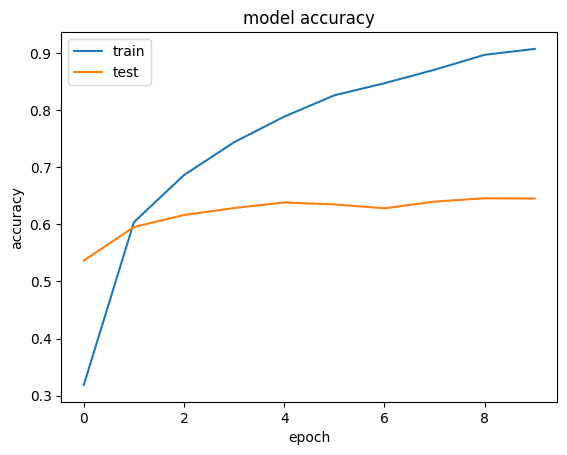

In [27]:
plt.plot(M.history['acc'])
plt.plot(M.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

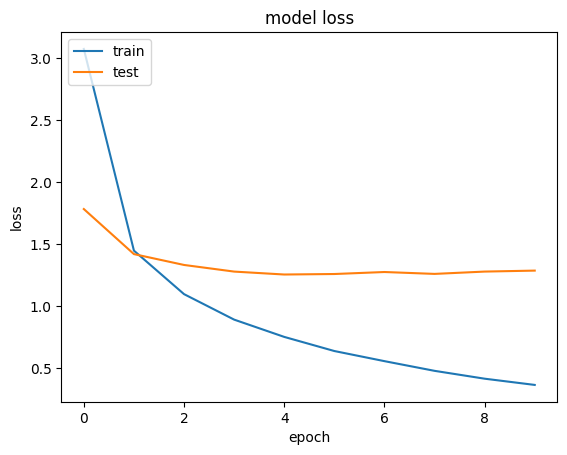

In [28]:
plt.plot(M.history['loss'])
plt.plot(M.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [29]:
I="/kaggle/input/dog-breed-identification1/Dog Breed Identification using Transfer Learning/test/0a8d8dda0e354c0571c8d47600ab39a3.jpg"

In [30]:
id2breed = {i: name for i, name in enumerate(breed)}

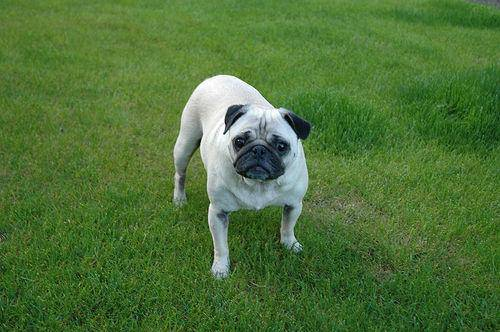

In [31]:
import PIL 
PIL.Image.open(I)

In [32]:
image = read_image(I, 224)
image = np.expand_dims(image, axis=0)
pred = model.predict(image)[0]
label_idx = np.argmax(pred)
breed_name = id2breed[label_idx]
print(breed_name)

1/1 [==============================] - 1s 849ms/step
pug


In [33]:
I1="/kaggle/input/dog-breed-identification1/Dog Breed Identification using Transfer Learning/test/00a3edd22dc7859c487a64777fc8d093.jpg"

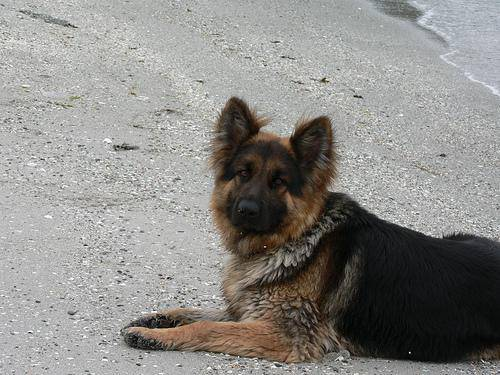

In [34]:
PIL.Image.open(I1)

In [35]:
image = read_image(I1, 224)
image = np.expand_dims(image, axis=0)
pred = model.predict(image)[0]
label_idx = np.argmax(pred)
breed_name = id2breed[label_idx]
print(breed_name)

1/1 [==============================] - 0s 24ms/step
australian_terrier
